# Insights from City Supply and Demand Data
Source: https://platform.stratascratch.com/data-projects/insights-city-supply-and-demand-data

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
sd = pd.read_csv("./datasets/dataset_1.csv")

### (1) Data manipulation

In [200]:
# Fix column names
sd.columns = [c.strip().replace(" ", "_") for c in sd.columns]
sd = sd.rename({"Time_(Local)": "Time"}, axis=1)
sd["Date"] = sd.Date.ffill()

sd = sd.assign(
    datets=lambda x: pd.to_datetime(x.Date, format="%d-%b-%y"),
    Weekday=lambda x: x.datets.dt.weekday,
    Weekend=lambda x: np.where(
        (
            ((x.Weekday == 4) & (x.Time >= 17))
            | (x.Weekday == 5)
            | ((x.Weekday == 6) & (x.Time < 3))
        ),
        1,
        0,
    ),
    request_past8hr=lambda x: x.Requests.rolling(8).sum(),
    zeroes_past72hr=lambda x: x.Zeroes.rolling(72).sum(),
    eyeballs_past72hr=lambda x: x.Eyeballs.rolling(72).sum(),
    zero_to_eye_p72=lambda x: x.zeroes_past72hr / x.eyeballs_past72hr,
)

sd = sd.sort_values(["Date", "Time"])
sd

,Date,Time,Eyeballs,Zeroes,Completed_Trips,Requests,Unique_Drivers,datets,Weekday,Weekend,request_past8hr,zeroes_past72hr,eyeballs_past72hr,zero_to_eye_p72
0,10-Sep-12,7,5,0,2,2,9,2012-09-10,0,0,NaN,NaN,NaN,NaN
1,10-Sep-12,8,6,0,2,2,14,2012-09-10,0,0,NaN,NaN,NaN,NaN
2,10-Sep-12,9,8,3,0,0,14,2012-09-10,0,0,NaN,NaN,NaN,NaN
3,10-Sep-12,10,9,2,0,1,14,2012-09-10,0,0,NaN,NaN,NaN,NaN
4,10-Sep-12,11,11,1,4,4,11,2012-09-10,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,24-Sep-12,2,3,3,0,2,0,2012-09-24,0,0,22.0,468.0,2207.0,0.212053
332,24-Sep-12,3,3,3,0,1,0,2012-09-24,0,0,17.0,468.0,2207.0,0.212053
333,24-Sep-12,4,1,1,0,0,0,2012-09-24,0,0,14.0,469.0,2208.0,0.212409
334,24-Sep-12,5,4,2,1,1,3,2012-09-24,0,0,11.0,470.0,2211.0,0.212573


### (2) Questions

#### 1. Which date had the most completed trips during the two week period?

In [163]:
sd.groupby("Date", as_index=False)["Completed_Trips"].sum().nlargest(
    1, "Completed_Trips", keep="all"
)


,Date,Completed_Trips
12,22-Sep-12,248


#### 2. What was the highest number of completed trips within a 24 hour period?

In [193]:
sd.assign(trips_24h=lambda x: x.Completed_Trips.rolling(24).sum().shift(-23)).nlargest(
    1, "trips_24h"
)

,Date,Time,Eyeballs,Zeroes,Completed_Trips,Requests,Unique_Drivers,datets,Weekday,Weekend,request_past8hr,zeroes_past72hr,eyeballs_past72hr,zero_to_eye_p72,trips_24h
274,21-Sep-12,17,68,25,26,26,20,2012-09-21,4,1,65.0,212.0,1155.0,0.18355,278.0


#### 3. Which hour of the day had the most requests during the two week period?

In [165]:
sd.groupby("Time", as_index=False).Requests.sum().nlargest(1, "Requests", keep="all")

,Time,Requests
23,23,184


#### 4.What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)

In [195]:
sd.query("Weekend == 1").Zeroes.sum() / sd.Zeroes.sum() * 100

44.856543037088876

#### 5. What is the weighted average ratio of completed trips per driver during the two week period? Tip: "Weighted average" means your answer should account for the total trip volume in each hour to determine the most accurate number in whole period.

In [197]:
sd.Completed_Trips.sum() / sd.Unique_Drivers.sum()

0.5145118733509235

#### 6. In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.

In [220]:
sd.groupby("Time", as_index=False).request_past8hr.sum().nlargest(1, "request_past8hr")[
    "Time"
]

print("Time = 6:00PM - 1:00AM")

0    0
Name: Time, dtype: int64

#### 7. Driver supply always increases when demand increases during the two week period. Tip: Visualize the data to confirm your answer if needed.

While in most days, the driver supply increases when demand increases, it is not always true


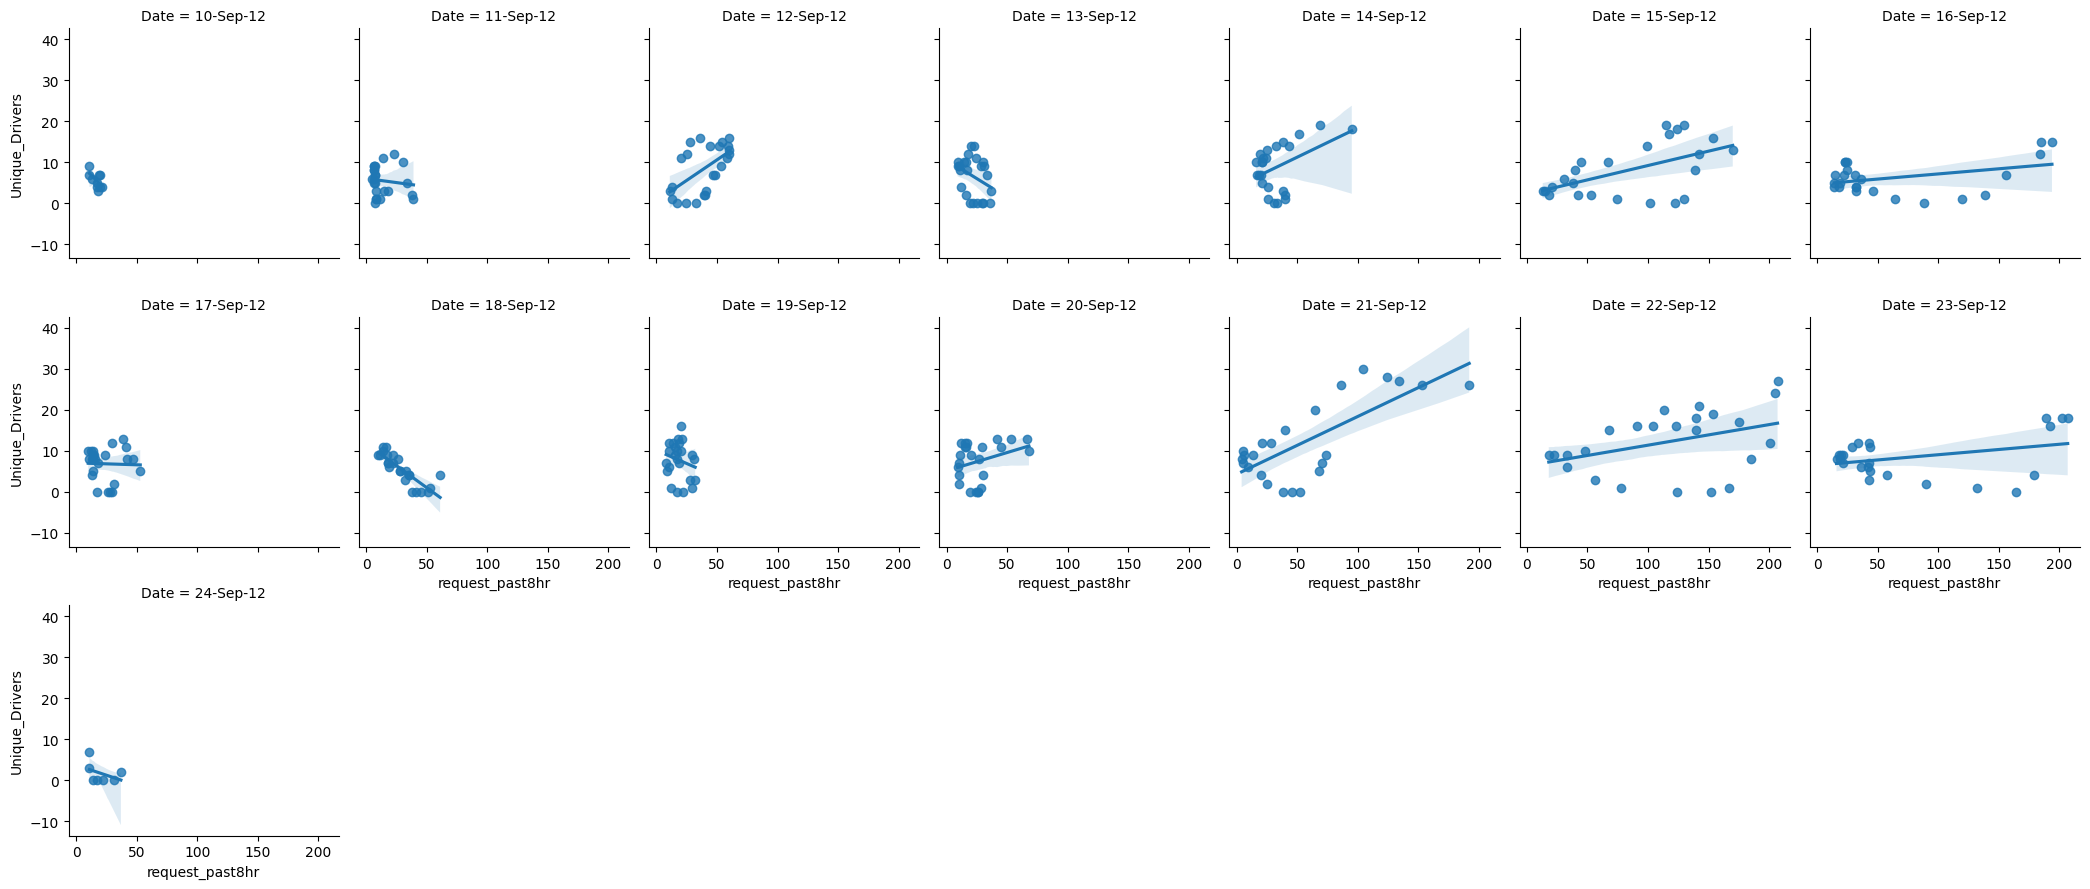

In [169]:
g = sns.FacetGrid(data=sd, col="Date", col_wrap=7)
g.map_dataframe(sns.regplot, x="request_past8hr", y="Unique_Drivers")

print(
    "While in most days, the driver supply increases when demand increases, it is not always true"
)

#### UF - 8. In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

In [170]:
sd.nlargest(1, "zero_to_eye_p72")

,Date,Time,Eyeballs,Zeroes,Completed_Trips,Requests,Unique_Drivers,datets,Weekday,Weekend,request_past8hr,zeroes_past72hr,eyeballs_past72hr,zero_to_eye_p72
189,18-Sep-12,4,1,1,0,0,0,2012-09-18,1,0,41.0,438.0,1495.0,0.292977


#### 9. If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to? Hint: Consider both rider eyeballs and driver supply when choosing

In [171]:
sd.groupby("Time", as_index=False).agg(
    eyeballs=("Eyeballs", "sum"), unique_drivers=("Unique_Drivers", "sum")
).assign(eye_to_driver=lambda x: x.eyeballs / x.unique_drivers).nlargest(
    1, "eye_to_driver"
)

,Time,eyeballs,unique_drivers,eye_to_driver
23,23,488,119,4.10084


#### 10.True or False: There is exactly two weeks of data in this analysis

In [172]:
print(sd.datets.max())
print(sd.datets.min())
print("No, there are 15 days in total")

2012-09-24 00:00:00
2012-09-10 00:00:00
No, there are 15 days in total


#### 11. Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e when are supply and demand at both their natural minimums) Tip: Visualize the data to confirm your answer if needed

In [186]:
smz = sd.groupby("Time", as_index=False).agg(
    eyeballs=("Eyeballs", "mean"), Unique_drivers=("Unique_Drivers", "mean")
)
print(smz.head(5))
print("Both demand (eyeballs) and supply (drivers) are at minimum at 4:00AM")


   Time   eyeballs  Unique_drivers
0     0  24.214286        7.928571
1     1  14.785714        6.714286
2     2  12.142857        4.428571
3     3   5.928571        2.857143
4     4   2.071429        0.642857


<Axes: xlabel='Time', ylabel='N'>

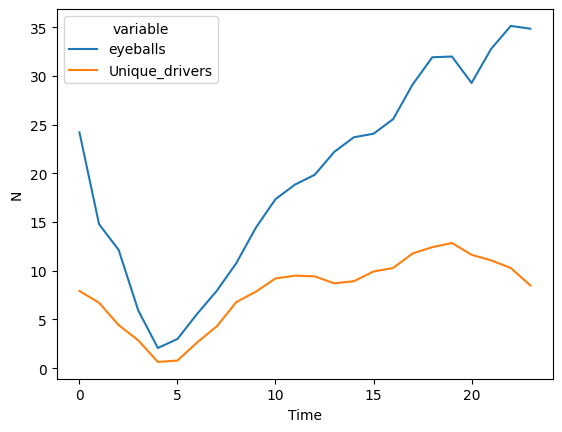

In [184]:
smz_long = pd.melt(
    smz, id_vars="Time", value_vars=["eyeballs", "Unique_drivers"], value_name="N"
)
smz_long.head(5)

sns.lineplot(smz_long, x="Time", y="N", hue="variable")